# Importing functions and data

## file locations

Supplementary Table 1 must be in the same directory as this notebook, or you will need to change this address!  
Similarly so does the FosJun reference structure

In [1]:
table_S1 = '../TableS1_epistasis_all_double_mutants.xlsx'
fosjun_xtal = './1FOS_fosjun.pdb'

Outputs from this notebook go to certain directories- uncomment these to make them here:

In [1080]:
# ! mkdir ./results/
# ! mkdir ./results/plots/
# ! mkdir ./results/tables/
# ! mkdir ./results/plots/fitness_distributions
# ! mkdir ./results/plots/data_completeness
# ! mkdir ./results/plots/epi_dists
# ! mkdir ./supplementary_figures/secondary_structure
# ! mkdir ./additional_data/gb1_subsampling/precision

## imports

Required python modules, and custom scripts are in "DMS_to_3D.py"

In [3]:
from DMS_to_3D import *
sns.set_style('whitegrid')
%matplotlib inline

## load in mutation scans

load in paper datasets from supplemental table

In [4]:
epistasis_tables = pd.ExcelFile(table_S1)

gb1 = load_sheet(epistasis_tables, 1)
ww = load_sheet(epistasis_tables, 2)
rrm = load_sheet(epistasis_tables, 3)
twister = load_sheet(epistasis_tables, 4)
fosjun = load_sheet(epistasis_tables, 5)
gfp = load_sheet(epistasis_tables, 6)

label long-range mutants, and filter out early stop mutants

In [366]:
# label the long-range mutants
for dms in [gb1, ww, rrm, twister, fosjun, gfp]:
    dms.loc[:, 'LR'] = dms['positions'].apply(lambda x: np.abs(x[1] - x[0]) > 5)

# exclude early stop mutations
ww = ww[~ww['mut'].apply(lambda x: '*' in str(x))]
rrm = rrm[~rrm['mut'].apply(lambda x: '*' in str(x))]

In [7]:
fosjun.loc[:, 'fit.proj.thermo'] = fosjun['double.mut.fit'] - fosjun['mepi_thermo']

fosjun.loc[:, 'Ws'] = fosjun.apply(
    lambda x: (x['fos.mut.fit'], x['jun.mut.fit']),
axis = 1)

## load in example xtal structures

For comparison, for each residue-residue pair in experimental structures, load in the nearest distances between heavy atoms.

In [9]:
gb1_pdbs = [('1gb1', 'A', 226), ('1igd', 'A', 226-5),
            ('1pga', 'A', 226), ('1pgb', 'A', 226),
            ('2gb1', 'A', 226), ('2igd', 'A', 226-5),
            ('2igh', 'A', 226-5), ('2lgi', 'A', 226),
            ('2n7j', 'A', 226), ('3gb1', 'A', 226),
            ('3mp9', 'A', 226-8)]
ww_pdbs =  [('1jmq', 'A', 0), ('4rex', 'A', -160),
            ('1k5r', 'A', 0), ('2lax', 'A', 0),
            ('2lay', 'A', 0), ('2ltw', 'A', 0)]
rrm_pdbs = [('1cvj', 'A', 27), ('2k8g', 'A', 27),
            ('4f02', 'A', 27), ('4f25', 'A', 27),
            ('4f26', 'A', 27)]
gfp_pdbs = [('1ema', 'A', 0)]
twister_pdbs = [('4oji', 'A', 0)]
fosjun_pdbs = [(fosjun_xtal, 'E', 0)]

gb1_xtals = get_dists(gb1_pdbs, gb1)
ww_xtals = get_dists(ww_pdbs, ww)
rrm_xtals = get_dists(rrm_pdbs, rrm)
gfp_xtals = get_dists(gfp_pdbs, gfp)
twister_xtals = get_dists(twister_pdbs, twister)
fosjun_xtals = get_dists(fosjun_pdbs, fosjun)
fosjun = fosjun.rename(columns = {'dist.'+fosjun_pdbs[0][0]: 'dist.1fos'})

Concerning Fos-Jun, the distances to compare against are across the dimer. For convenience, we use a pdb file where the relevant region of Fos is indexed 1-32 and that of Jun is 33-64 (additional data).

## Computing fitness from mutational scan data

The data is typically acquired as some form of pre- and post-selection abundance (e.g. 'input' and 'output' counts). 
Fitness under the selection pressure can be found by comparing the enrichment (e.g. input / output) of a mutant to that of the wild-type (e.g. normalize by WT).  
We use the same fitness metrics as computed by the authors of each study:
- GB1 (Olson et al.), log enrichment in sequence counts corresponding to individual proteins
- WW (Araya et al.) slope fit to log enrichment over 3 rounds of selection of bacteriophage
- RRM (Melamed et al.) log enrichment in sequence counts corresponding to yeast grown in competition
- Fos-Jun (Diss and Lehner) log enrichment in sequence counts (scaled by OD) corresponding to yeast grown in competition
- Twister ribozyme (Kobori and Yokobashi) log fraction of cleaved sequences

## Computing epistasis from fitness

Epistasis is generally computed as the deviation in double mutant fitness from that expected by a model projected from the composite single mutations.  
The better the projection approximates the effect of independent mutations, the more the computed epistasis should reflect true genetic interactions.  
The authors in most of the above studies either chose to project fitness with the multiplicative model because of its conceptual agreement with the nature of their measurement, or tried multiple possible models and found that model to be the best projection of double mutant fitness.  

The one exception is the Diss and Lehner, who also fit a specific thermodynamic model to their data- and found this to result in less systematic error in projecting double mutant fitness. In that case, we use their computed epistasis, expecting it to be better reflective of true genetic interactions.  

In all other cases, we have used the multiplicative model $ \epsilon = lnW_{AB} - lnW_A - lnW_B $  
though we anticipate specific thermodynamic models could improve the precision of epistasis values in reflecting 3D interactions.

# Fitness distributions

## Visualizing measurement floors, continuity VS bimodality, and model efficacy in projecting double mutants

The very large datasets (GB1, Fos-Jun) take quite a while to plot- uncomment the plot you'd like to see-
by default, GB1 is already plotted- but executing the ell will run WW:

mkdir: ../results/plots/fitness_distributions: File exists


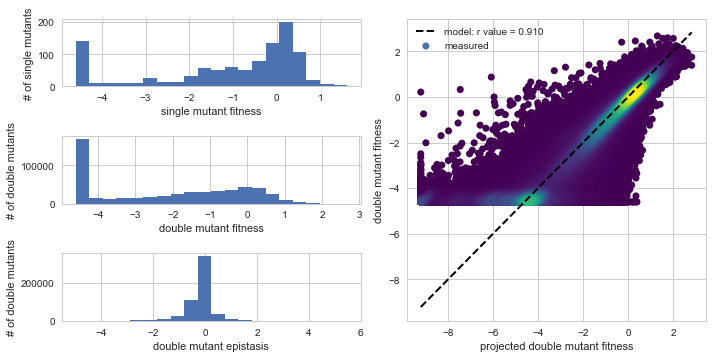

In [1220]:
plot_double_fitness(ww, outfile='./results/plots/fitness_distributions/ww_fit.png')

#plot_double_fitness(gb1, outfile='./results/plots/fitness_distributions/gb1_fit.png')
#plot_double_fitness(rrm, outfile='./results/plots/fitness_distributions/rrm_fit2.png')
#plot_double_fitness(fosjun, fit='double.mut.fit', proj='fit.proj.thermo', epi='mepi_thermo',
#                    fits='Ws', outfile='./results/plots/fitness_distributions/fosjun_fit.png')#
#plot_double_fitness(twister, outfile='./results/plots/fitness_distributions/twister_fit2.png')

# Data completeness

## Visualizing the completeness of each mutant scan, and local abscences in measurement coverage

Plotting just a few mutant coverage maps as examples- uncomment the others to create plots for other mutation scans:

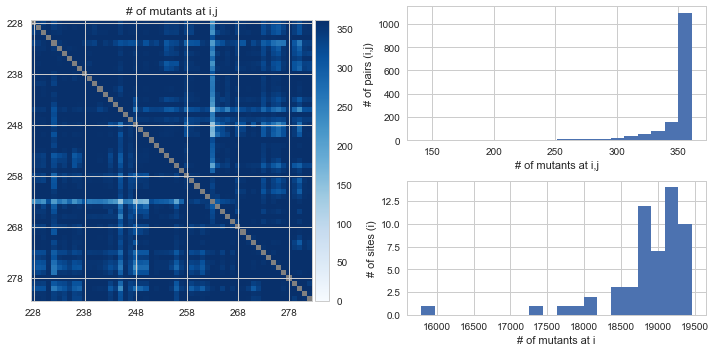

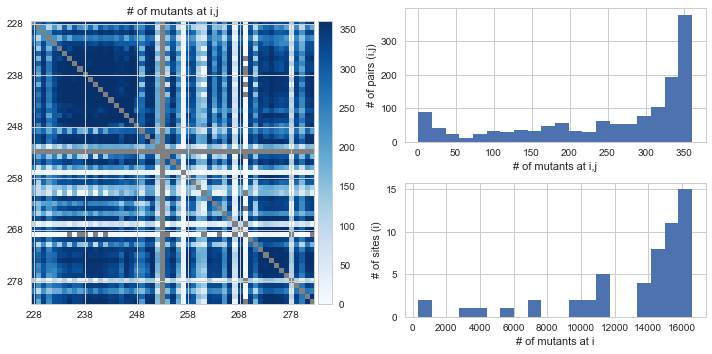

In [46]:
plot_mutant_coverage(gb1[gb1['Input Count'].gt(20)], np.arange(228, 282+1),
    outfile='./results/plots/data_completeness/gb1_inputGT20_coverage.png')


# many GB1 measurements likely obscure true epistasis- because they hit the measurement floor
plot_mutant_coverage(gb1[gb1['Input Count'].gt(20)
                         & gb1['lnWs'].apply(lambda x: x[0] > -4.5 and x[1] > -4.5)
                         & gb1['lnW'].gt(-4.5)], np.arange(228, 282+1),
    outfile='./results/plots/data_completeness/gb1_notMeasurementFloor_coverage.png')

#plot_mutant_coverage(ww, np.arange(170, 203+1),
#    outfile='./results/plots/data_completeness/ww_coverage.png')
#plot_mutant_coverage(rrm, np.arange(126, 199+1),
#    outfile='./results/plots/data_completeness/rrm_coverage.png')
#plot_mutant_coverage(twister, np.arange(7, 54+1), [0, 9],
#    outfile='./results/plots/data_completeness/twister_coverage.png')
#plot_mutant_coverage(fosjun, np.arange(1, 64+1),
#    outfile='./results/plots/data_completeness/fosjun_coverage.png')
#plot_mutant_coverage(gfp, np.arange(1, 235+1), n = 25,
#    outfile='./results/plots/data_completeness/gfp_coverage.png')

# Predicting 3D contacts from experimental epistasis

## Contact prediction method-- the i,j pairs with largest measured epistasis in any double mutant

The method for predicting contacts is very simple:
1. sort all double mutants by measured epistasis
2. keep only the top most epistatic mutant at each i,j site

The highest ranking ('top') i,j sites are therefore those with the strongest epistasis at any mutant measured at that site.  
These are the pairs we suspect are most likely in contact.

In [9]:
def most_epistatic_pairs(epi_table, epi='epi', sign='positive'):
    '''finds the double mutant with highest epistasis at each i-j pair'''

    top_pairs = epi_table.sort_values(epi, ascending=(sign != 'positive'))
    top_pairs = top_pairs.drop_duplicates('positions', keep='first')
    
    # record-keeping detail: how many mutants were measured at each site?
    num_pairs = epi_table.groupby('positions')['mut'].apply(len)
    num_pairs = num_pairs.reset_index().rename(columns = {'mut': 'num.muts'})
    top_pairs = pd.merge(top_pairs, num_pairs, on='positions')
    
    return(top_pairs)

### We found top pairs according to positive epistasis to correspond most strongly to 3D contacts:

In [367]:
gb1_top = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)])
ww_top = most_epistatic_pairs(ww)
rrm_top = most_epistatic_pairs(rrm, epi='Capped_Epistasis_score')
fosjun_top = most_epistatic_pairs(fosjun, 'mepi_thermo')
twister_top = most_epistatic_pairs(twister)
gfp_top = most_epistatic_pairs(gfp)

### Top pairs according to absolute and negative epistasis- not used for main results:

In [368]:
for dms in [gb1, ww, twister, gfp]:
    dms.loc[:, 'epi.abs'] = dms['epi'].apply(np.abs)

rrm.loc[:, 'epi.abs'] = rrm['Capped_Epistasis_score'].apply(np.abs)
fosjun.loc[:, 'epi.abs'] = fosjun['mepi_thermo'].apply(np.abs)


gb1_abs = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)], epi='epi.abs')
ww_abs = most_epistatic_pairs(ww, epi='epi.abs')
rrm_abs = most_epistatic_pairs(rrm, epi='epi.abs')
fosjun_abs = most_epistatic_pairs(fosjun, epi='epi.abs')
twister_abs = most_epistatic_pairs(twister, epi='epi.abs')
gfp_abs = most_epistatic_pairs(gfp, epi='epi.abs')

gb1_neg = most_epistatic_pairs(gb1[gb1['Input Count'].gt(20)], sign='negative')
ww_neg = most_epistatic_pairs(ww, sign='negative')
rrm_neg = most_epistatic_pairs(rrm, epi='Capped_Epistasis_score', sign='negative')
fosjun_neg = most_epistatic_pairs(fosjun, epi='mepi_thermo', sign='negative')
twister_neg = most_epistatic_pairs(twister, sign='negative')
gfp_neg = most_epistatic_pairs(gfp, sign='negative')

## Top epistasis pair distribution

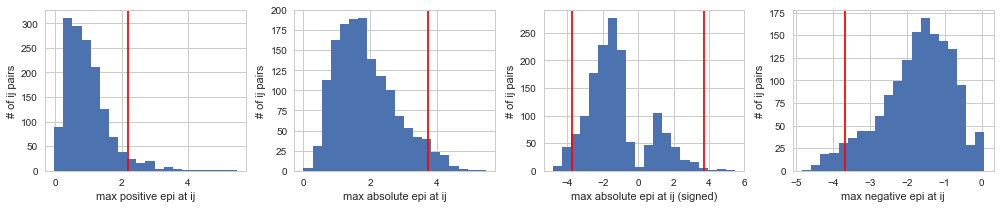

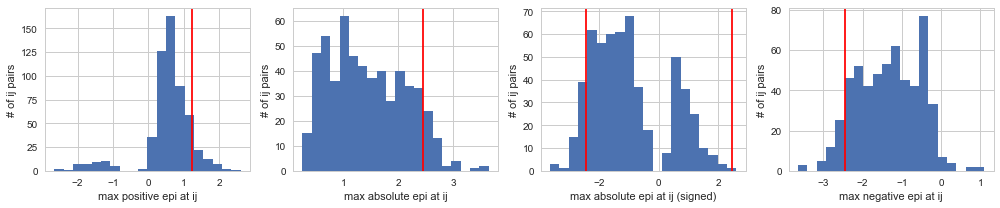

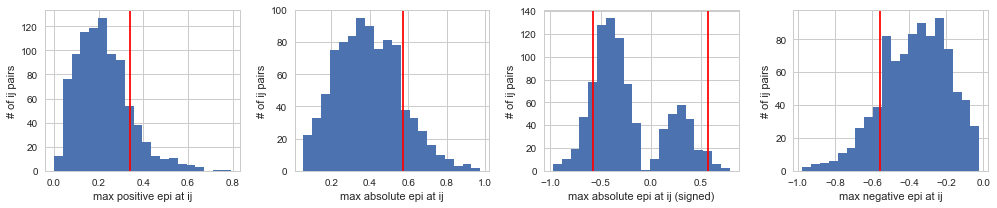

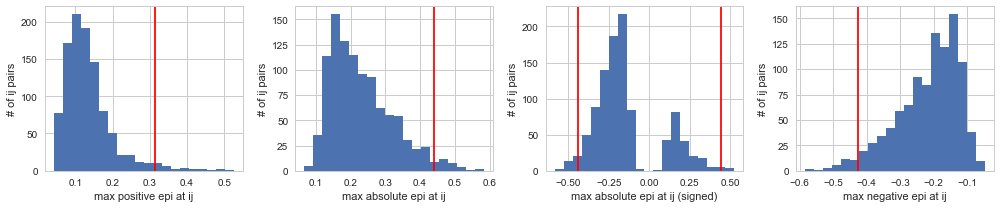

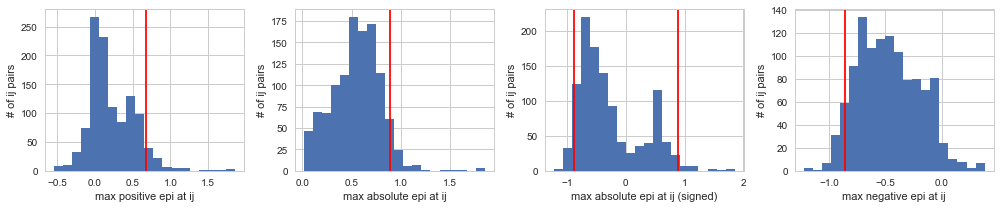

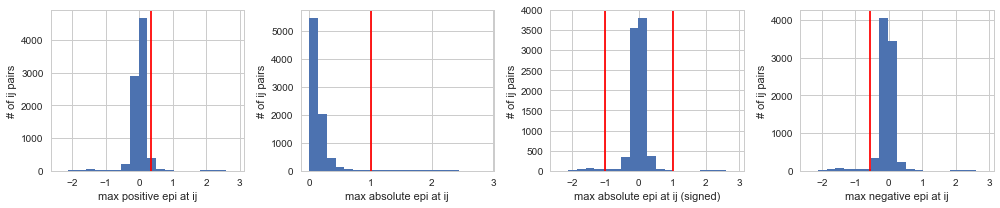

In [1083]:
# for each dataset, iterate over the top pairs by positive, absolute, and negative epi
epi_pairs = [
    (gb1_top, gb1_abs, gb1_abs, gb1_neg),
    (ww_top, ww_abs, ww_abs, ww_neg),
    (rrm_top, rrm_abs, rrm_abs, rrm_neg),
    (fosjun_top, fosjun_abs, fosjun_abs, fosjun_neg),
    (twister_top, twister_abs, twister_abs, twister_neg),
    (gfp_top, gfp_abs, gfp_abs, gfp_neg)
]

Ls = [56, 37, 75, 32, 48, 236]
es = ['epi', 'epi.abs', 'epi', 'epi']
rrm_es = ['Capped_Epistasis_score', 'epi.abs',
          'Capped_Epistasis_score', 'Capped_Epistasis_score']
fosjun_es = ['mepi_thermo', 'epi.abs',
             'mepi_thermo', 'mepi_thermo']

list_es = [es, es, rrm_es, fosjun_es, es, es]

ts = ['max positive epi at ij', 'max absolute epi at ij',
     'max absolute epi at ij (signed)', 'max negative epi at ij']

flder = './results/plots/epi_dists/'
outs = ['gb1', 'ww', 'rrm', 'fosjun', 'twister', 'gfp']

for v, out, L, Es in zip(epi_pairs, outs, Ls, list_es):
    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(14, 3)
    for x, ax, t, e in zip(v, axs, ts, Es):
        ax.hist(x[e].dropna(), bins=20);
        ax.set_xlabel(t)
        ax.set_ylabel('# of ij pairs')
        ax.axvline(x[x['LR']][e].iloc[L-1], color='red')
        if 'signed' in t:
            ax.axvline(-x[x['LR']][e].iloc[L-1], color='red')
    fig.tight_layout()
    fig.savefig(flder + out + '_max_epi_dists--w_cutoff2.png', dpi=300)

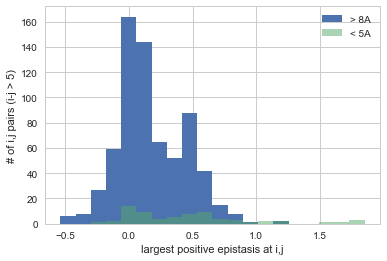

In [23]:
x = twister_top[twister_top['LR']]
e = 'epi'

fig, ax = plt.subplots(1)
bins = np.histogram(x[e], bins=20)
bins = ax.hist(x[x['dist.any_struct'].gt(8)][e], bins=bins[1])
ax.hist(x[x['dist.any_struct'].lt(5)][e], bins=bins[1], alpha=0.5)
ax.legend(['> 8A', '< 5A'])
ax.set_xlabel('largest positive epistasis at i,j')
ax.set_ylabel('# of i,j pairs (i-j > 5)')
fig.savefig('../twister--max_epi_pair--contact_vs_8Anoncontact.svg')

## Epistasis maps

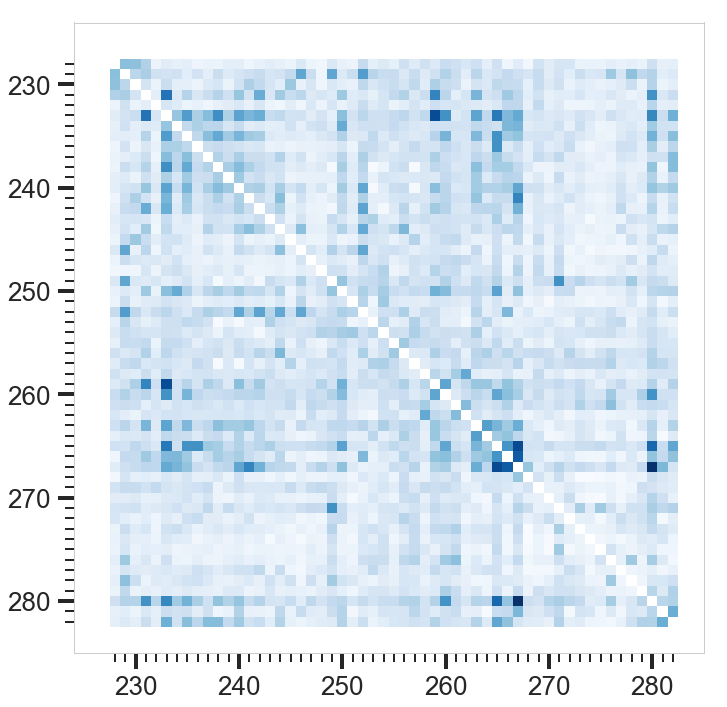

In [158]:
fig, ax, hmap = epi_map(gb1_top, [226, 282], tixm=(228, 283), tixM=(230, 290))
ax.tick_params(width=4, length=16, which='major')
ax.tick_params(width=2, length=9, which='minor')
fig.set_size_inches(10, 10)
fig.tight_layout()

plt.grid(True, which='major')
fig.savefig('../figures/Figure1_top_epi_vals_10grid-b10.svg')

plt.grid(True, which='minor')
fig.savefig('../figures/Figure1_gb1_top_epi_vals_full_grid-b10.svg')

plt.grid(False, which='major')
plt.grid(False, which='minor')
fig.savefig('../figures/Figure1_gb1_top_epi_vals_NOgrid-b10.svg')

## Comparing top epistasis pairs to 3D distances

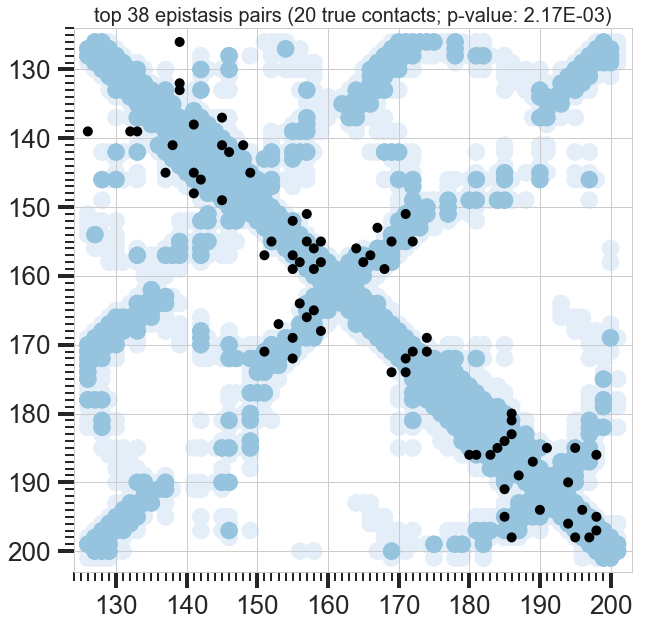

In [1076]:
compare_contacts(
    rrm_xtals, rrm_top, rrm, 'min_overall', 'dist.any_struct', 'rrm',
    [38], (126, 201), (130, 210), (120, 201))

mkdir: ../supplementary_figures/epi_contacts: File exists
mkdir: ../supplementary_figures/epi_contacts/gb1: File exists


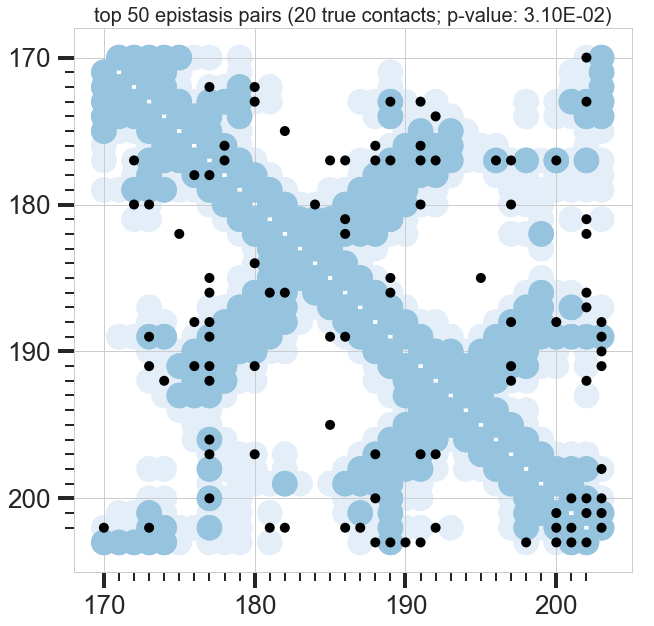

In [336]:
!mkdir ../supplementary_figures/epi_contacts
!mkdir ../supplementary_figures/epi_contacts/gb1
#!mkdir ../supplementary_figures/epi_contacts/ww
#!mkdir ../supplementary_figures/epi_contacts/rrm
#!mkdir ../supplementary_figures/epi_contacts/fosjun
#!mkdir ../supplementary_figures/epi_contacts/twister
#!mkdir ../supplementary_figures/epi_contacts/gfp

#compare_contacts(
#    gb1_xtals, gb1_top, gb1, 'min_overall', 'dist.any_struct', 'gb1',
#    [10, 20, 30, 40, 50, 60, 70, 100], (226, 283), (230, 290), (226, 283))
#compare_contacts(
#    ww_xtals3, ww_top, ww, 'min_overall', 'dist.any_struct', 'ww',
#    [5, 10, 20, 30, 40, 50], (10, 43), (10, 50), (10, 43), oL=160, s = 650)
#compare_contacts(
#    rrm_xtals, rrm_top, rrm, 'min_overall', 'dist.any_struct', 'rrm',
#    [10, 15, 20, 25, 30, 40, 50, 60], (126, 201), (130, 210), (120, 201))
#compare_contacts(
#    fosjun_xtals, fosjun_top, fosjun, 'min_overall', 'dist.any_struct', 'fosjun',
#    [3, 5, 7, 9, 20, 30], (1, 63), (10, 70), (1, 64))
#compare_contacts(
#    twister_xtals, twister_top, twister, 'min_overall', 'dist.any_struct', 'twister',
#    [5, 10, 20, 30, 40, 50], (1, 55), (10, 60), (1, 55))
#compare_contacts(
#    gfp_xtals, gfp_top, gfp, 'min_overall', 'dist.any_struct', 'gfp',
#    [75], (0, 240), (10, 240), (1, 1), tN=20)


## Secondary structure prediction method

### Extract secondary structure regions from experimental structures for comparison

In [511]:
gb1_ss = merge_ss(gb1_pdbs).set_index('id').loc[np.arange(228, 283)]
gb1_ss.to_csv('../supplementary_tables/secondary_scores_vs_xtal_sec_struct.csv')
print(''.join(gb1_ss['joint']))

#results in:
gb1_betastrands = [(228, 234), (239, 246), (268, 272), (277, 281)]
gb1_helix = (249, 263)

EEEEEEECCCCEEEEEEEECCHHHHHHHHHHHHHHHCCCCEEEEECCCCEEEEEC


In [515]:
ww_ss = merge_ss(ww_pdbs).set_index('id').loc[np.arange(10, 45)]
ww_ss.to_csv('../supplementary_tables/ww_secondary_scores_vs_xtal_sec_struct.csv')
print(''.join(ww_ss['joint']))

#results in:
ww_betastrands = [(17, 22), (26, 31), (36, 38)]

CCCCCCCEEEEEECCCEEEEEECCCCEEECCCHHH


In [549]:
rrm_ss = merge_ss(rrm_pdbs).set_index('id').loc[np.arange(50, 201)]
rrm_ss.to_csv('../supplementary_tables/rrm_secondary_scores_vs_xtal_sec_struct.csv')
print(''.join(rrm_ss['joint']))

#results in:
rrm_betastrands = [(64,71), (78,86), (103,113), (127,131), (152,157), (168,172), (187,190), (193,199)]
rrm_helices = [(51,61), (89,96), (119,122), (139,147), (175,181)]


CHHHHHHHHHHHCCEEEEEEEECCCCCCEEEEEEEEECCHHHHHHHHCCCCCCEECCEECEEEECCCCCHHHHCCCCEEEEECCCCCCCHHHHHHHHHCCCCEEEEEECCECCECCCCEEEEECCHHHHHHHCCCCCEEEECCEEEEEEEC


### Visualization

In [936]:
gb1_2ndary = compute_SS(gb1_top, fill=np.nan)
ww_2ndary = compute_SS(ww_top, fill=np.nan)
rrm_2ndary = compute_SS(rrm_top, fill=np.nan)

## Comparing predicted secondary structure to experimental

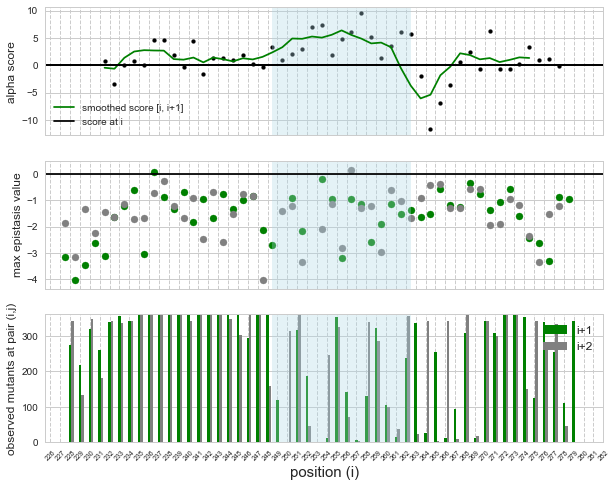

In [1084]:
gb1_scores = compute_SS(gb1_top, e='epi', l=1, r=1, acut=acut, bcut=bcut,
                   na=4, nb=2)
fig, ax = plot_alpha_pairs(gb1[gb1['lnW'].gt(-4.5) & gb1['lnW.proj'].gt(-4.5)
                              & gb1['lnWs'].apply(lambda x: (x[0] > -4.5) and (x[1] > -4.5))],
                           gb1_scores, np.arange(0, 57)+226, o=0, fs=7)
#ax[0].set_ylim(-11, 14)

for i in [0, 1, 2]:
    rect = patches.Rectangle((gb1_helix[0],-30), gb1_helix[1]-gb1_helix[0], 600, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
    ax[i].add_patch(rect)

fig.savefig('../gb1_alpha_coverage_and_scores-floor.png', dpi=300)

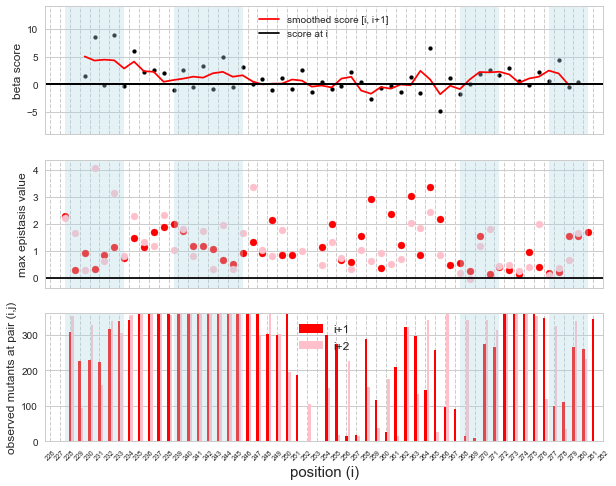

In [792]:

fig, ax = plot_beta_pairs(gb1[gb1['lnW'].gt(-4.5) & gb1['lnW.proj'].gt(-4.5)
                              & gb1['lnWs'].apply(lambda x: (x[0] > -4.5) and (x[1] > -4.5))],
                          gb1_scores, np.arange(0, 57)+226, o=0, fs=7)

for (a,b) in gb1_betastrands:
    for i in [0, 1, 2]:
        rect = patches.Rectangle((a,-10), b-a, 1000, linewidth=1, edgecolor=None, facecolor='lightblue', alpha=0.33)
        ax[i].add_patch(rect)
ax[0].set_ylim(-9, 14)
        
fig.savefig('../gb1_beta_coverage_and_scores-floor.png', dpi=300)

# Contact prediction and folding from smaller libraries

### Experimental strategies for mutant libraries

In [884]:
any_pair = gb1[gb1['Input Count'].gt(20)]
one_del = any_pair[any_pair['lnWs'].apply(lambda x: (x[0] < -2) or (x[1] > -2))]
both_del = any_pair[any_pair['lnWs'].apply(lambda x: (x[0] < -2) and (x[1] > -2))]

### Sampling and measuring 3D contact precision

In [888]:
library_sizes = np.array([0.005, 0.01, 0.02, 0.05]) *  len(gb1)
library_sizes = library_sizes.astype(int)

sample_precisions(both_del, library_sizes, num_draws=2)

,library size,L/2,L,L/2 (i-j > 5),L (i-j > 5)
0,2679,0.428571,0.339286,0.214286,0.232143
1,5359,0.535714,0.482143,0.428571,0.321429
2,10718,0.714286,0.571429,0.500000,0.321429
3,26795,0.785714,0.607143,0.535714,0.375000


### Sampling constraints for folding

In [895]:
sampled_epi_pairs = sample_constraints(both_del, library_sizes, num_draws=5)

# return one table as an example
sampled_epi_pairs[library_sizes[0]][0].head()

,A_i,A_j,cn,i,j
0,L,Y,3.080727,233,259
1,V,D,2.793050,265,266
2,G,V,2.372401,267,280
3,L,D,2.227567,233,266
4,T,E,2.153573,281,282


## additional mutation strategy: pairwise swaps

In [855]:
gb1_swaps = gb1[gb1['mut'].apply(lambda x: (x[0][-1] == x[1][0]) or (x[1][-1] == x[0][0])) & gb1['Input Count'].gt(20)]
gb1_swaps_top = gb1_swaps.sort_values('epi', ascending=False).drop_duplicates('positions', keep='first')

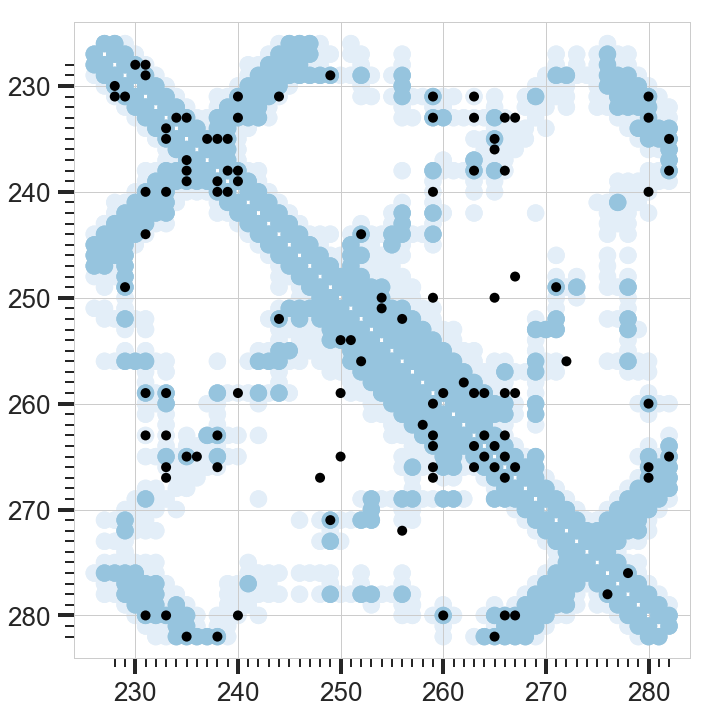

In [856]:
xt = gb1_xtals.reset_index()
xt.loc[:, 'positions'] = xt.apply(lambda x: (x['level_0'], x['level_1']), axis=1)

for d in ['min_overall']:
    fig, ax = plotContacts(xt, lims=[226, 56+226], offset=226, dist=d, tixm=(228, 283), tixM=(230, 290))
    plotIJ(gb1_swaps_top.head(56), ax=ax, z=2, s=100)
    ax.tick_params(width=4, length=16, which='major')
    ax.tick_params(width=2, length=9, which='minor')
    fig.tight_layout()
    
    plt.grid(True, which='major')
    #fig.savefig('../additional_data/gb1_swaps-100-pairs-vs-'+d+'_10grid-b10.svg')

# Extra analyses (not in the paper):

## Precision vs epistasis rank

### precision of L pairs, at descending epistasis rank (pairs ranked from N -> N+L)

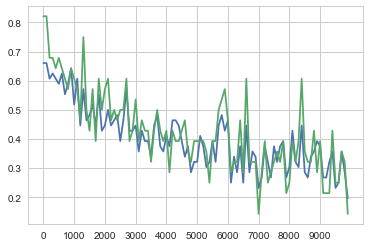

In [666]:
def rolling_top_L_precision(tbl, L, n = 100, M = 56, d='dist.any_struct'):
    '''precision of L pairs, at descending epistasis
    rank (pairs ranked from N -> N+L)'''
    l = []
    for i in np.arange(L)[::n]:
        z = np.mean(tbl.tail(len(tbl) - i).drop_duplicates(
            'positions').head(M)[d].lt(5))
        l.append(z)
    return(l)

L = 10000
n = 100

# L and L/2
M = 56
plt.plot(np.arange(L)[::n], rolling_top_L_precision(gb1_top, L, n, 56))
plt.plot(np.arange(L)[::n], rolling_top_L_precision(gb1_top, L, n, 28))

plt.gca().set_xticks(np.arange(0, 10000)[::1000]);

### < 5A precision of top N pairs (pairs ranked from 1 -> N)

Precision falls off steeply after the top L most epistatic pairs- note: this will be a property of any metric that ranks true 3D contacts towards the top, because there are only so many contacts total (a # proportional to L).

/Users/nrollins/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


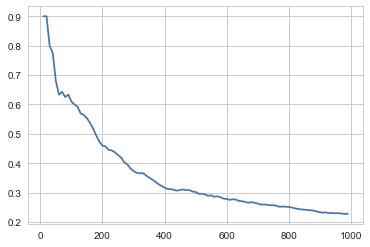

In [924]:
def rolling_precision(tbl, L = 100, n = 5, d='dist.any_struct'):
    '''precision of the top N pairs (ranked from 1 -> N)'''
    l = []
    for i in np.arange(L)[::n]:
        l.append(np.mean(tbl.head(i).drop_duplicates(
            'positions')[d].lt(5)))
    return(l)

L = 1000
n = 10

plt.plot(np.arange(L)[::n], rolling_precision(gb1_top, L, n))

# alternative approaches: limit pairs per position, no measurement floor correction, average product correction

## limit pairs per position

In [834]:
gb1_top_dedup = dedup_sites(gb1_top, n=3)

## no measurement floor correction

In [ ]:
gb1.loc[:, 'epi.nocap'] = gb1.apply(
    lambda x: x['lnW'] - np.sum(x['lnWs']), axis=1)

## average product correction

In [926]:
gb1_top_apc = APC(gb1_top, 'epi')
gb1_nocap_apc = APC(gb1_top_nocap, 'epi.nocap')

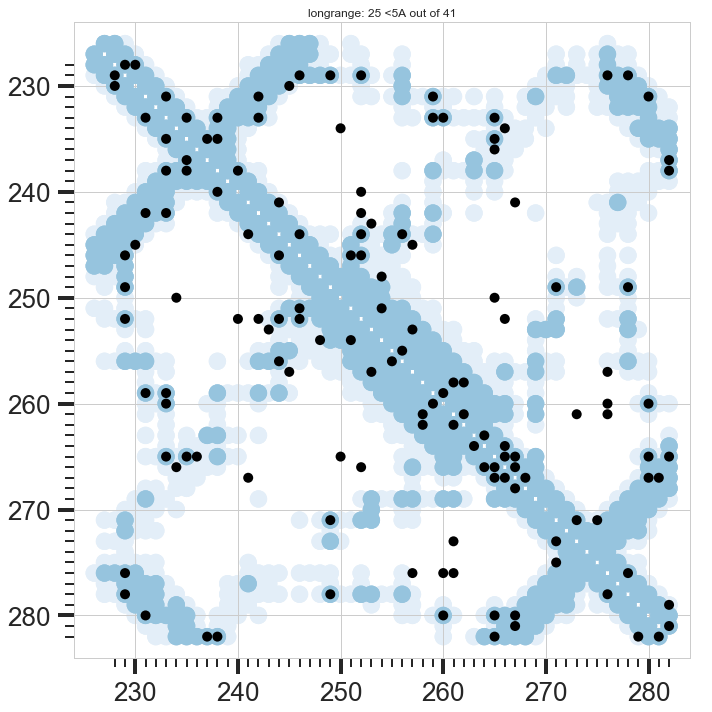

In [927]:
xt = gb1_xtals.reset_index()
xt.loc[:, 'positions'] = xt.apply(lambda x: (x['level_0'], x['level_1']), axis=1)

X = gb1_top_apc
N = 70

for d in ['min_overall']:
    top = X.head(N)

    fig, ax = plotContacts(xt, lims=[226, 56+226], offset=226, dist=d, tixm=(228, 283), tixM=(230, 290))
    plotIJ(top, ax=ax, z=2, s=100)
    ax.tick_params(width=4, length=16, which='major')
    ax.tick_params(width=2, length=9, which='minor')
    plt.grid(True, which='major')
    fig.tight_layout()
    
    lr = top[top['LR']]
    n = np.sum(lr['dist.any_struct'].lt(5))
    ax.set_title('longrange: ' + str(n) + ' <5A out of ' + str(len(lr)) )

#fig.savefig('../other/gb1_top'+str(N)+'LRpairs_no_floor_correction--with_APC.png', dpi=250)

# Reporting precision tables

In [1013]:
Lbasic = [5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 150, 200]
jobs = [
    ('GB1', Lbasic + [28, 56], gb1_top),
    ('WW ', Lbasic + [18, 36], ww_top),
    ('RRM', Lbasic + [38, 75], rrm_top),
    ('FosJun', Lbasic + [16, 32], fosjun_top),
    ('Twister', Lbasic + [24, 48], twister_top),
    ('GFP', Lbasic + [119, 238], gfp_top)
]

with pd.ExcelWriter('precision_tables.xlsx') as myexcel:
    for tag, Ls, dms in jobs:
        rows = [str(l) for l in Ls] + ['LR ' + str(l) for l in Ls]
        result = precision_table(dms, Ls).loc[:, rows].T
        result.to_excel(myexcel, sheet_name=tag)

## Writing out secondary structure files

In [1019]:
with pd.ExcelWriter('ss_comparison34232.xlsx') as myexcel:
    gb1_compare_ss.to_excel(myexcel, sheet_name='GB1')
    ww_compare_ss.to_excel(myexcel, sheet_name='WW')
    rrm_compare_ss.to_excel(myexcel, sheet_name='RRM')

## Writing out precision tables

In [1078]:
Lbasic = [5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 150, 200]
jobs = [
    ('GB1', Lbasic + [28, 56], gb1_top),
    ('WW ', Lbasic + [18, 36], ww_top),
    ('RRM', Lbasic + [38, 75], rrm_top),
    ('FosJun', Lbasic + [16, 32], fosjun_top),
    ('Twister', Lbasic + [24, 48], twister_top),
    ('GFP', Lbasic + [119, 238], gfp_top)
]

with pd.ExcelWriter('precision_tables.xlsx') as myexcel:
    for tag, Ls, dms in jobs:
        rows = [str(l) for l in Ls] + ['LR ' + str(l) for l in Ls]
        result = precision_table(dms, Ls).loc[:, rows].T
        result.to_excel(myexcel, sheet_name=tag)